<!--TITLE:Data Augmentation-->

# Introduction #

Now that you've learned the fundamentals of convolutional classifiers, you're ready to move on to more advanced topics.

In this lesson, you'll learn a trick that can give a boost to your image classifiers: it's called **data augmentation**. 

# The Usefulness of Fake Data #

The best way to improve the performance of a machine learning model is to train it on more data. The more examples the model has to learn from, the better it will be able to recognize which differences in images matter and which do not. More data helps the model to *generalize* better.

One easy way of getting more data is to use the data you already have. If we can transform the images in our dataset in ways that preserve the class, we can teach our classifier to ignore those kinds of transformations. For instance, whether a car is facing left or right in a photo doesn't change the fact that it is a *Car* and not a *Truck*. So, if we **augment** our training data with flipped images, our classifier will learn that "left or right" is a difference it should ignore.

And that's the whole idea behind data augmentation: add in some extra fake data that looks reasonably like the real data and your classifier will improve.

# Using Data Augmentation #

Typically, many kinds of transformation are used when augmenting a dataset. These might include rotating the image, adjusting the color or contrast, warping the image, or many other things, usually applied in combination. Here is a sample of the different ways a single image might be transformed.

<figure>
<img src="https://i.imgur.com/UaOm0ms.png" width=400, alt="Sixteen transformations of a single image of a car.">
</figure>

Data augmentation is usually done *online*, meaning, as the images are being fed into the network for training. Recall that training is usually done on mini-batches of data. This is what a batch of 16 images might look like when data augmentation is used.

<figure>
<img src="https://i.imgur.com/MFviYoE.png" width=400, alt="A batch of 16 images with various random transformations applied.">
</figure>

Each time an image is used during training, a new random transformation is applied. This way, the model is always seeing something a little different than what it's seen before. This extra variance in the training data is what helps the model on new data.

It's important to remember though that not every transformation will be useful on a given problem. Most importantly, whatever transformations you use should not mix up the classes. If you were training a [digit recognizer](https://www.kaggle.com/c/digit-recognizer), for instance, rotating images would mix up '9's and '6's. In the end, the best approach for finding good augmentations is the same as with most ML problems: try it and see!

# Example - Training with Data Augmentation #

Keras lets you augment your data in two ways. The first way is to include it in the data pipeline with a function like [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). The second way is to include it in the model definition by using Keras's **preprocessing layers**. This is the approach that we'll take. The primary advantage for us is that the image transformations will be computed on the GPU instead of the CPU, potentially speeding up training.

In this exercise, we'll learn how to improve the classifier from Lesson 1 through data augmentation. This next hidden cell sets up the data pipeline.

In [1]:

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    '../input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.


2021-11-09 00:11:53.608832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 00:11:53.697837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 00:11:53.698540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 00:11:53.705682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 5051 files belonging to 2 classes.


## Step 2 - Define Model ##

To illustrate the effect of augmentation, we'll just add a couple of simple transformations to the model from Tutorial 1.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
# these are a new feature in TF 2.2
from tensorflow.keras.layers.experimental import preprocessing


pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5), # contrast change by up to 50%
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

## Step 3 - Train and Evaluate ##

And now we'll start the training!

In [3]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

2021-11-09 00:12:00.140735: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-09 00:12:03.240879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


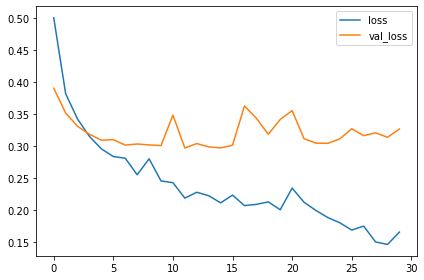

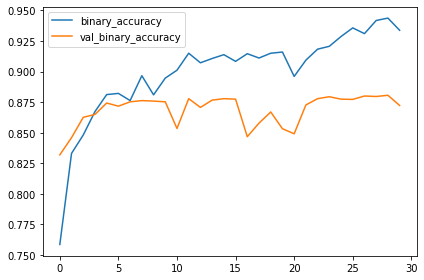

In [4]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

The training and validation curves in the model from Tutorial 1 diverged fairly quickly, suggesting that it could benefit from some regularization. The learning curves for this model were able to stay closer together, and we achieved some modest improvement in validation loss and accuracy. This suggests that the dataset did indeed benefit from the augmentation.

# Your Turn #

Move on to the [**Exercise**](https://www.kaggle.com/kernels/fork/11991328) to apply data augmentation to the custom convnet you built in Lesson 5. This will be your best model ever!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*